#Simple RNN for audio samples
In this trial we decided to create a simple RNN, calculating the results with and without a dropout layer.

In [ ]:
import numpy as np 
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import gc
import time
from tqdm import tqdm, tqdm_notebook; tqdm.pandas() # Progress bar
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
import csv
import random

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import keras
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import (Dense, SimpleRNN, ELU,
                          Dropout, LeakyReLU, Conv1D, BatchNormalization)
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Set the seed value for experiment reproducibility.
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)

We define two function to create the audio samples windows

In [ ]:
def create_windows(signal, window_size, hop_length):
    num_samples = len(signal)
    num_windows = 1 + (num_samples - window_size) // hop_length
    windows = np.zeros((num_windows, window_size))

    for i in range(num_windows):
        start = i * hop_length
        end = start + window_size
        windows[i] = signal[start:end]

    return windows

def split_wav_in_windows(df):
    X = []
    window_size = 2048
    hop_length = 724
    for _,row in tqdm(df.iterrows()):
        y,sr = librosa.load(row.path, sr=16000)
        x = create_windows(y, window_size, hop_length)
        X.append(x.transpose())
    return X

Open the csv and create the train, validation and test sets.

In [ ]:
df = pd.read_csv("splitted_total15.csv")
path = df["path"].values
labels = df["label"].values

# Preprocess dataset and create validation sets
X1 = np.array(split_wav_in_windows(df))

train_paths, test_paths, train_labels, test_labels = train_test_split(X1, labels, test_size=0.2, random_state=123)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.15, random_state=123)

1235it [00:23, 52.87it/s]


Here we create the network.

In [ ]:
input_shape=(2048,263)
model = keras.Sequential()
model.add(SimpleRNN(156,input_shape=input_shape))
model.add(Dense(48, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 156)               65520     
                                                                 
 dense (Dense)               (None, 48)                7536      
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 73,105
Trainable params: 73,105
Non-trainable params: 0
_________________________________________________________________


We define the early stopping mechanism, the batch size and the number of epochs. Then, we fit the model.

In [ ]:
learning_rate = 0.00001
optimizer = optimizers.Adam(learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
batch_size=80
epochs = 140
history = model.fit(train_paths, train_labels, epochs=epochs, batch_size = batch_size,
                    validation_data=(val_paths, val_labels), shuffle=False, callbacks=[early_stopping])

Epoch 1/140
11/11 [==============================] - 33s 2s/step - loss: 0.7018 - accuracy: 0.4625 - val_loss: 0.6902 - val_accuracy: 0.5436
Epoch 2/140
11/11 [==============================] - 23s 2s/step - loss: 0.6997 - accuracy: 0.4708 - val_loss: 0.6896 - val_accuracy: 0.5503
Epoch 3/140
11/11 [==============================] - 23s 2s/step - loss: 0.6980 - accuracy: 0.4815 - val_loss: 0.6891 - val_accuracy: 0.5503
Epoch 4/140
11/11 [==============================] - 24s 2s/step - loss: 0.6964 - accuracy: 0.4911 - val_loss: 0.6885 - val_accuracy: 0.5503
Epoch 5/140
11/11 [==============================] - 25s 2s/step - loss: 0.6949 - accuracy: 0.4970 - val_loss: 0.6876 - val_accuracy: 0.5638
Epoch 6/140
11/11 [==============================] - 26s 2s/step - loss: 0.6935 - accuracy: 0.5113 - val_loss: 0.6867 - val_accuracy: 0.5638
Epoch 7/140
11/11 [==============================] - 27s 3s/step - loss: 0.6930 - accuracy: 0.5101 - val_loss: 0.6862 - val_accuracy: 0.5705
Epoch 8/140
1

Plotting the loss function and the accuracy for both train and validation set.

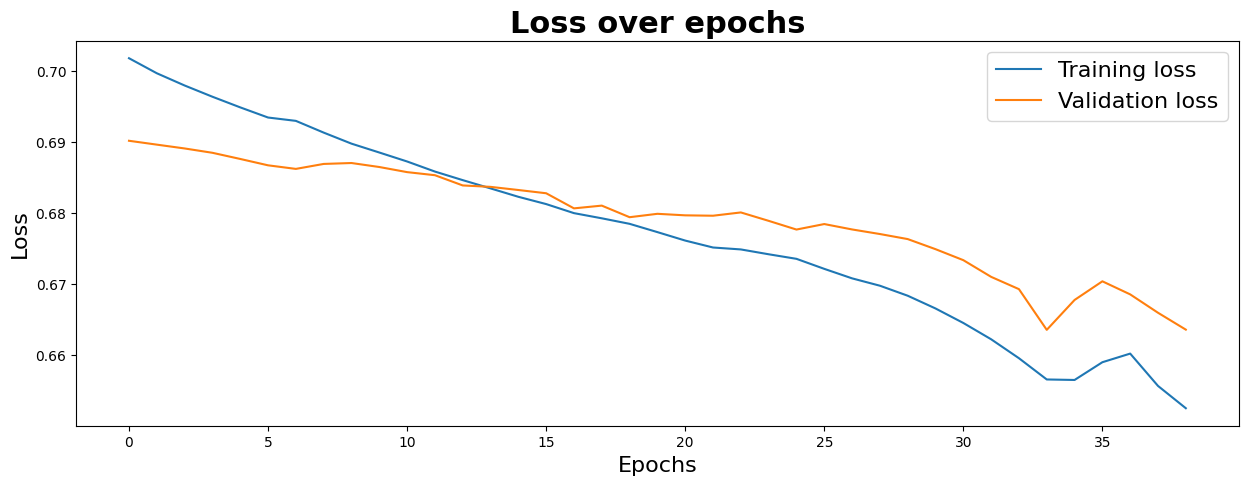

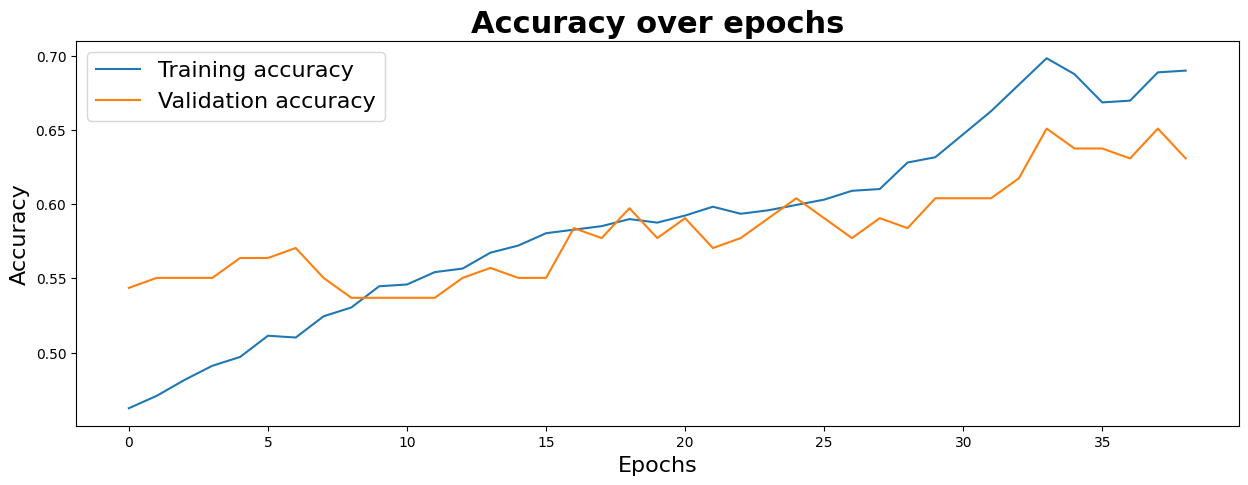

In [ ]:
# Visualize loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_executed = early_stopping.stopped_epoch + 1
if epochs_executed != 1:
    rg = epochs_executed
else:
    rg = epochs    
plt.figure(figsize=(15,5))
plt.plot(range(rg), loss)
plt.plot(range(rg), val_loss)
plt.title('Loss over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training loss', 'Validation loss'], fontsize=16)
plt.show()

# Visualize Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15,5))
plt.plot(range(rg), acc)
plt.plot(range(rg), val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

Evaluating the model on the test set, calculating the confusion matrix, the f1-score, the recall and the accuracy

8/8 [==============================] - 7s 709ms/step


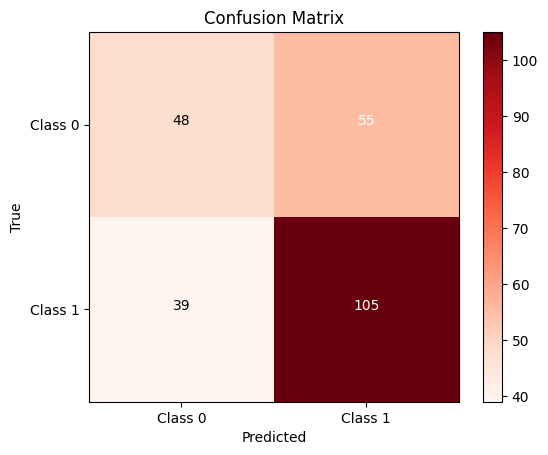

              precision    recall  f1-score   support

           0       0.55      0.47      0.51       103
           1       0.66      0.73      0.69       144

    accuracy                           0.62       247
   macro avg       0.60      0.60      0.60       247
weighted avg       0.61      0.62      0.61       247



In [ ]:
test_loss, test_accuracy = model.evaluate(test_paths, test_labels)


# Make predictions using your model
prediction = model.predict(test_paths)
# Convert the predicted probabilities to class labels (0 or 1 in this case)
y_pred = (prediction > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
# Add text annotations within each cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

from sklearn.metrics import classification_report


# Ottieni le predizioni del modello sul test set
predicted_probabilities = prediction.flatten()  # Appiattisci le probabilità
predicted_labels = (predicted_probabilities >= 0.5).astype(int)

# Calcola l'F1-score, il recall e l'accuratezza
report = classification_report(test_labels, predicted_labels)
print(report)

In [ ]:
model.save("Notebook/RNN_Audio/")

INFO:tensorflow:Assets written to: Notebook/RNN_Audio/assets
